# Can we use ground sensors to evaluate London residence's exposure to high air pollution?
categories: [data wrangling, data exploration]

### Author
- Christina Last. [The Alan Turing Institute](https://www.turing.ac.uk/people/research-engineering/christina-last).
GitHub: [@ChristinaLast](https://github.com/ChristinaLast/) Twitter: [@last_christina](https://twitter.com/last_christina)

All the authors above contributed to this data story story with ideas, code development and story telling.

### Reviewers
- [insert name here]

## London air quality
Some of the main drivers of climate change result in poor air quality in urban areas. While climate change is abstract and global, air quality is local and personal:
a few years back, poor air quality was reported outside thousands of schools in the UK a recent legal ruling determined that air pollution was the cause of death for an 8-year-old London girl
the Mayor of London has plans to reduce air pollution at schools

The story reveals which communities are most impacted by air pollution in London. It also explores the risk of walking to school by different routes, and possibly looking over time at locations where school street schemes have been implemented.

### Downloading the air quality data locally
This Turing Data Story uses data from [Global Clean Air](https://www.globalcleanair.org/innovative-air-quality-monitoring/london-uk/breathe-london-data/).
The Data is available to download from the link.

### Analysis Outline
1. Download and process data from PM2.5 and NO2 data
2. Combine the different datasets into a single table by joining on datetime.
    Calculate age standardised mortality rates from mortality counts.
    Replicate the ONS analysis, looking at mortality rate by region.
    Visualise the distribution of COVID-19 deaths across the UK.
    Segment the data into time periods, corresponding to the different stages of lockdown.
    Explore at the relationship between our two key metrics (deprivation and mortality rates) in the different time periods.


#### TODO:
##### Visualisations
- [ ] Add title
- [ ] add x/y labels

##### Modelling
- [ ] Created stacked model to predict PM2.5 and NO2
- [ ] extract regions of high PM2.5 and NO2 values (using WHO thresholds)
- [ ] explore interaction between schools and high values

##### Miscellaneous
- [ ] find out what causes the NO2 spike in early August/early September

#### :wrench: Setup

We begin by setting up our environment and importing various python libraries that we will be using for the analysis.
In particular, `pandas` and `numpy` are key data science libraries used for data processing. `matplotlib` and `seaborn` will help us visualise our data.

## :bar_chart: Data Exploration
We are using data from [Global Clean Air](https://www.globalcleanair.org/innovative-air-quality-monitoring/london-uk/breathe-london-data/)
which contains information about pollution’s health effects, as well as readily available — and understandable — air pollution data and analysis.
The Breathe London pilot project mapped and measured pollution across the capital, led for two years by Environmental Defense Fund Europe and launched in partnership with the Mayor of London and leading science and technology experts.

The dataset contains more than 100 lower-cost sensor pods and specially-equipped Google Street View cars,
Breathe London complemented and expanded upon London’s existing monitoring networks.
The project aimed to help people better understand their local air quality and support cities around the world with future monitoring initiatives.

### Reading in the Data

In [1]:
from pathlib import Path
# reading in the data
import pandas as pd

root_data_path = Path("data")

def read_local_data(data_dir, filename):
    data_path = Path(str(data_dir)+filename).absolute()
    return pd.read_csv(data_path)



pm25_metadata = read_local_data(root_data_path, "/PM2_5_site_metadata_20180901_20201130.csv")
pm25_full_network = read_local_data(root_data_path, "/20180901_20201130_PM2_5_AQMesh_Scaled_Dataset_UGM3.csv")
no2_metadata = read_local_data(root_data_path, "/NO2_site_metadata_20180901_20201130.csv")
no2_full_network = read_local_data(root_data_path, "/20180901_20201130_NO2_AQMesh_Scaled_Dataset_UGM3.csv")

In [2]:
pm25_metadata.head()

,pod_id_location,start_date_UTC,end_date_UTC,relocate_date_UTC,location_name,Borough,Type,ULEZ,Latitude,Longitude,X_Coord,Y_Coord,Distance_from_Road,Height,Site_Type
0,1245,15/02/2019 12:00,30/11/2020 23:59,NaN,Dollis Road,Barnet,Kerbside,No,51.604486,-0.206551,524299.9229,191038.6267,1.2,3.100,NaN
1,2245,03/05/2019 10:00,30/11/2020 23:59,NaN,Great Ormond St Hospital,Camden,Roadside,Yes,51.521880,-0.120434,530499.4261,182002.3181,2.5,2.800,Hospital
2,3245,04/10/2018 18:00,30/11/2020 23:59,NaN,Savernake Road,Camden,Urban Background,No,51.555485,-0.152338,528191.7240,185682.9587,5.0,2.297,School
3,4245,06/03/2019 14:35,30/11/2020 23:59,NaN,Wandsworth Road,Lambeth,Kerbside,No,51.475735,-0.131209,529881.9791,176852.2693,0.5,3.120,NaN
4,5245,06/03/2019 15:55,30/11/2020 23:59,NaN,Garrett Lane,Wandsworth,Kerbside,No,51.440399,-0.186775,526117.9944,172825.4459,1.0,3.445,Individual


In [3]:
# And displaying the data itself
pm25_full_network.head()

,date_UTC,pm2_5_ugm3,pod_id_location,pod_id,location_name,ratification_status
0,2019-02-15 13:00:00,20.17,1245,1245,Dollis Road,P
1,2019-02-15 14:00:00,18.47,1245,1245,Dollis Road,P
2,2019-02-15 15:00:00,19.84,1245,1245,Dollis Road,P
3,2019-02-15 16:00:00,36.68,1245,1245,Dollis Road,P
4,2019-02-15 17:00:00,20.18,1245,1245,Dollis Road,P


We can see that there is a csv recording the timeseries value of the PM2.5 reading (hourly) and a csv containing information
about the location of the sensor. They both share a commin id in the column `pod_id_location`. Lets join the PM2.5 data and
the NO2 data to one dataframe containing the timeseries values and location information

In [4]:
def join_network_metadata(network_df, metadata_df, col_to_join):
    return network_df.merge(metadata_df, on=col_to_join, how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')


pm25_network_metadata = join_network_metadata(pm25_full_network, pm25_metadata,  "pod_id_location")
no2_network_metadata = join_network_metadata(no2_full_network, no2_metadata,  "pod_id_location")
no2_network_metadata.head()

,date_UTC,no2_ugm3,pod_id_location,pod_id,location_name,ratification_status,start_date_UTC,end_date_UTC,relocate_date_UTC,Borough,Type,ULEZ,Latitude,Longitude,X_Coord,Y_Coord,Distance_from_Road,Height,Site_Type
0,2019-02-15 17:00:00,61.99,1245,1245,Dollis Road,P,15/02/2019 16:45,30/11/2020 23:59,NaN,Barnet,Kerbside,No,51.604486,-0.206551,524299.9229,191038.6267,1.2,3.1,NaN
1,2019-02-15 18:00:00,67.33,1245,1245,Dollis Road,P,15/02/2019 16:45,30/11/2020 23:59,NaN,Barnet,Kerbside,No,51.604486,-0.206551,524299.9229,191038.6267,1.2,3.1,NaN
2,2019-02-15 19:00:00,72.61,1245,1245,Dollis Road,P,15/02/2019 16:45,30/11/2020 23:59,NaN,Barnet,Kerbside,No,51.604486,-0.206551,524299.9229,191038.6267,1.2,3.1,NaN
3,2019-02-15 20:00:00,67.24,1245,1245,Dollis Road,P,15/02/2019 16:45,30/11/2020 23:59,NaN,Barnet,Kerbside,No,51.604486,-0.206551,524299.9229,191038.6267,1.2,3.1,NaN
4,2019-02-15 21:00:00,59.78,1245,1245,Dollis Road,P,15/02/2019 16:45,30/11/2020 23:59,NaN,Barnet,Kerbside,No,51.604486,-0.206551,524299.9229,191038.6267,1.2,3.1,NaN


Here we can see the NO2 data has successfully been joined with the metadata available for the sensor location. We drop repeated columns
using a regex filter on our suffix `_DROP` added to duplicated columns within the merge.

### Preliminary Data Exploration

In [5]:
no2_numeric_cols = ["no2_ugm3", "Distance_from_Road","Height"]
pm25_numeric_cols = ["pm2_5_ugm3", "Distance_from_Road","Height"]

In [6]:
# Data distribution
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pm25_network_metadata[pm25_numeric_cols].describe()

,pm2_5_ugm3,Distance_from_Road,Height
count,1399810.00000,1305125.00000,1399810.00000
mean,-104.43024,4.61179,3.27866
std,321.54480,6.96932,1.95759
min,-999.00000,0.00000,1.50000
25%,4.28000,1.00000,2.90000
50%,6.40000,2.00000,3.00000
75%,11.20000,5.70000,3.12600
max,469.59000,50.00000,19.50000


In [7]:
no2_network_metadata[no2_numeric_cols].describe()

,no2_ugm3,Distance_from_Road,Height
count,1555296.00000,1448871.00000,1555296.00000
mean,-15.62420,4.18273,3.29576
std,223.95386,6.57160,1.80931
min,-999.00000,0.00000,1.50000
25%,22.28000,1.00000,2.93000
50%,30.02000,1.67000,3.00000
75%,40.85000,5.00000,3.12000
max,628.12000,50.00000,20.00000


The distribution of the numeric variables looks positively skewed and these variables may need to be transformed for modelling.
It looks like `NA` values are coded differently depending on the variable. For example, the value `-999.00000` seems to indicate
null values in bopth PM2.5 and NO2 readings.
Lets take a further look at the number of `NA` values in the data and where they exist.

In [8]:
#nan values
pm25_network_metadata.isnull().sum()

date_UTC                     0
pm2_5_ugm3                   0
pod_id_location              0
pod_id                       0
location_name                0
ratification_status          0
start_date_UTC               0
end_date_UTC                 0
relocate_date_UTC      1344809
Borough                      0
Type                         0
ULEZ                         0
Latitude                     0
Longitude                    0
X_Coord                      0
Y_Coord                      0
Distance_from_Road       94685
Height                       0
Site_Type               684790
dtype: int64

In [9]:
#nan values
no2_network_metadata.isnull().sum()

date_UTC                     0
no2_ugm3                     0
pod_id_location              0
pod_id                       0
location_name                0
ratification_status          0
start_date_UTC               0
end_date_UTC                 0
relocate_date_UTC      1438569
Borough                      0
Type                         0
ULEZ                         0
Latitude                     0
Longitude                    0
X_Coord                      0
Y_Coord                      0
Distance_from_Road      106425
Height                       0
Site_Type               848060
dtype: int64

Here we can see that most of the `NA` values exist in the variables `relocate_date_UTC`, `Distance_from_Road` and `Site_Type`.
We can deal with these missing data through recoding and omitting the values themselves, or imputing them.

In [10]:
from numpy import nan
# replace '-999.00000' values with 'nan'
def recode_missing_values(data, col_to_recode, value_to_recode):
    return data[col_to_recode].replace(value_to_recode, nan)

pm25_network_metadata['pm2_5_ugm3'] = recode_missing_values(pm25_network_metadata, "pm2_5_ugm3", -999.00000)
no2_network_metadata['no2_ugm3'] = recode_missing_values(no2_network_metadata, "no2_ugm3", -999.00000)

In [11]:
#no. of unique values
no2_network_metadata_unique = no2_network_metadata.nunique(dropna = False)
no2_network_metadata_unique.sort_values()[:10]

ratification_status      1
ULEZ                     2
Type                     4
Site_Type                5
relocate_date_UTC       21
end_date_UTC            30
Borough                 34
Height                  55
Distance_from_Road      59
pod_id                 107
dtype: int64

In [12]:
#no. of unique values
pm25_network_metadata_unique = pm25_network_metadata.nunique(dropna = False)
pm25_network_metadata_unique.sort_values()[:10]

ratification_status     1
ULEZ                    2
Type                    4
Site_Type               5
relocate_date_UTC       6
end_date_UTC            6
Borough                29
Height                 49
Distance_from_Road     52
pod_id                 95
dtype: int64

Here we can see the number of unique values for each of our datasets. We can see there are `107` `NO2` unique stations
in across 34 boroughs in London, and `95` stations capturing PM2.5 values across 29 boroughs in London.

### Plotting Geospatial distribution

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
%matplotlib inline

pm25_network_metadata_gdf = gpd.GeoDataFrame(pm25_metadata, geometry=gpd.points_from_xy(pm25_metadata.Longitude, pm25_metadata.Latitude))
no2_network_metadata_gdf = gpd.GeoDataFrame(no2_metadata, geometry=gpd.points_from_xy(no2_metadata.Longitude, no2_metadata.Latitude))

In order to display the map of the station locations accurately, we need to set the Coordinate reference system of the georeferences information in our
`GeoDataFrame`. This requires knowing some information on [projection systems](https://geopandas.org/docs/user_guide/projections.html), but for now
we know that any geospatial information given in `Latitude` and `Longitude` is well-projected using the `EPSG:4326` coordinate reference system.


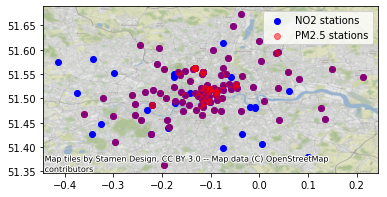

In [14]:
def set_crs(gdf, espg):
    return gdf.set_crs(epsg=espg, inplace=True)

pm25_network_metadata_gdf = set_crs(pm25_network_metadata_gdf, 4326)
no2_network_metadata_gdf = set_crs(no2_network_metadata_gdf, 4326)

f, ax = plt.subplots(1)
no2_network_metadata_gdf.plot(ax=ax, color="blue", figsize=(9, 9), label="NO2 stations")

pm25_network_metadata_gdf.plot(ax=ax, color="red", figsize=(9, 9), alpha=0.5, label="PM2.5 stations")
cx.add_basemap(ax, crs=no2_network_metadata_gdf.crs.to_string())
leg = ax.legend()
plt.show()

In the above map (using the metadata of the individual stations) we can see that there are more N02 stations than PM2.5 (also indicated by the no. of unique stations from each
`dataframe`, and that these stations are located slightly further out. The stations in purple indicate an overlapping of a PM2.5 and NO2
sensor in the same location.
### Converting data
Lets create some additional columns to summarise the data with, and lets merge both dataframes on the newly created `date` column.

In [24]:
#conversion
def create_datetime_columns(data, date_column):
    data["timestamp"] = data[date_column].astype("datetime64")
    data["date"] = data["timestamp"].dt.to_period("d")
    data["month"] = data["timestamp"].dt.to_period("M")
    return data

no2_network_metadata = create_datetime_columns(no2_network_metadata, "date_UTC")
pm25_network_metadata = create_datetime_columns(pm25_network_metadata, "date_UTC")

def groupby_date_column(data, cols_to_group, grouping_col):
    return data[cols_to_group].groupby(grouping_col).mean().reset_index()

pm25_grouped = groupby_date_column(pm25_network_metadata, ["date", "pm2_5_ugm3"], "date")
no2_grouped = groupby_date_column(no2_network_metadata, ["date", "no2_ugm3"], "date")

#merging dataframes together for comparison plots.
pm25_no2_grouped = pm25_grouped[["date", "pm2_5_ugm3"]].merge(no2_grouped[["date", "no2_ugm3"]], on="date")

pm25_no2_grouped

,date,pm2_5_ugm3,no2_ugm3
0,2018-09-26,8.46286,83.84458
1,2018-09-27,8.29125,97.22446
2,2018-09-28,5.73375,34.15138
3,2018-09-29,8.23389,53.33000
4,2018-09-30,8.27319,37.17500
...,...,...,...
793,2020-11-27,23.37291,45.25448
794,2020-11-28,38.93289,41.93009
795,2020-11-29,31.05356,36.53198
796,2020-11-30,17.71516,30.04076


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

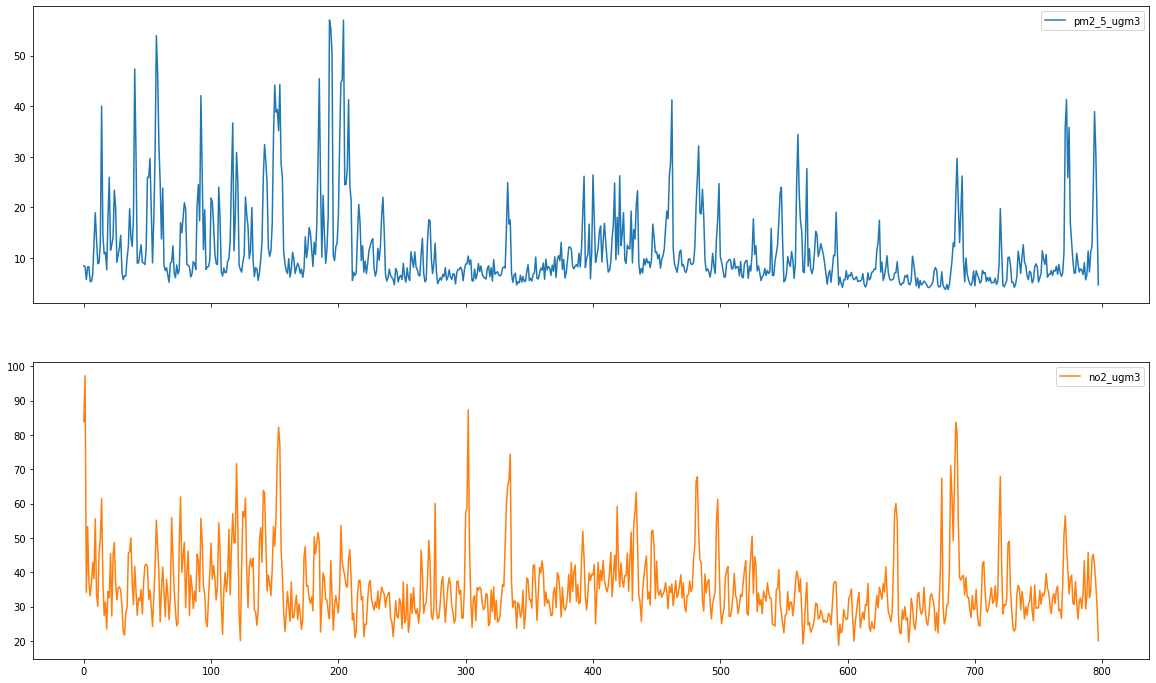

In [28]:
pm25_no2_grouped.plot.line(subplots=True, figsize=(20, 12))

We can see the average daily PM2.5 and NO2 results plotted above. These demonstrate that there is high variability in the
average daily pollution levels across the city, reflected in the spikey line graphs. We can also see some seasonal variability,
with higher PM2.5 and NO2 concentrations being recorded in the winter months (September to February) in 2018-2019. We cannot see
the same increase in emissions for the following winter (2019-2020), potentially due to lockdowns being enforced in the late winter to early
spring 2020.
#### Change in the daily mean of pollutant concentrations in a local view
Lets see how the levels of pollutants are varying, taking their local daily average. (ID's are unique)

In [45]:
def generate_sample_location(data, id_col, no_of_rows):
    test_sensor_ids = data[id_col].unique()[:no_of_rows]
    return data[data[id_col].isin(test_sensor_ids)]

sample_pm25_data = generate_sample_location(pm25_network_metadata, "pod_id", 5)
sample_no2_data = generate_sample_location(no2_network_metadata, "pod_id", 5)

After sampling the yearly concentration values from the first 5 unique station ID's I want to plot the air pollution
concentrations for each of the location.

array([[<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>]], dtype=object)

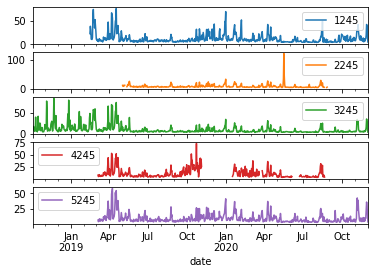

In [47]:
sample_pm25_data[["date","pod_id", "pm2_5_ugm3"]].groupby(["date","pod_id"]).mean()["pm2_5_ugm3"]\
    .unstack().plot(subplots=True, layout=(5,1))

array([[<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>]], dtype=object)

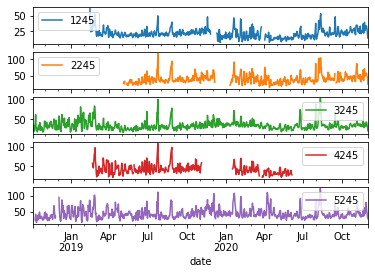

In [48]:
sample_no2_data[["date","pod_id", "no2_ugm3"]].groupby(["date","pod_id"]).mean()["no2_ugm3"]\
    .unstack().plot(subplots=True, layout=(5,1))

Here we can see the daily average pollution concentration data for the first 5 unique sensor ID's. The individual sensor readings
show there is a lot of missing data (at differing intervals for each sensor). We can also see all the sensors shows exhibit a spike
in NO2 concentrations in July/August 2019, and again in 2020.

#### Intra-day analysis
1.   During which time of the day was pollutant concentration the highest?
2.   How did the pollutant concentration change during the day?

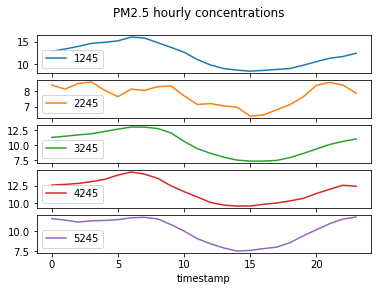

In [70]:
pm25_day_data = sample_pm25_data.groupby([sample_pm25_data["timestamp"].dt.hour,"pod_id"])["pm2_5_ugm3"].mean()
_ = pm25_day_data.unstack().plot(subplots=True, layout=(5,1), title="PM2.5 hourly concentrations")

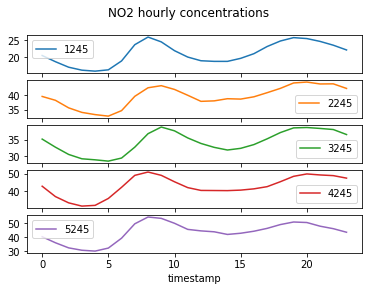

In [69]:
no2_day_data = sample_no2_data.groupby([sample_no2_data["timestamp"].dt.hour,"pod_id"])["no2_ugm3"].mean()
_ = no2_day_data.unstack().plot(subplots=True, layout=(5,1), title="NO2 hourly concentrations")

In [65]:
no2_feats_counts = no2_network_metadata['freq'] = no2_network_metadata.groupby('date')['date'].transform('count')

no2_feats_counts.sort_values()

1549270      24
1549261      24
93584        24
93583        24
93582        24
           ... 
455000     2256
455001     2256
74567      2256
454994     2256
1207150    2256
Name: date, Length: 1555296, dtype: int64

In [66]:
pm25_feats_counts = pm25_network_metadata['freq'] = pm25_network_metadata.groupby('date')['date'].transform('count')

pm25_feats_counts.sort_values()

306560       7
306558       7
306557       7
306556       7
306555       7
          ... 
468856    2184
468855    2184
468854    2184
849540    2184
561417    2184
Name: date, Length: 1399810, dtype: int64

Some of these locations have only seven data points per day (excluding NAs) we can consider removing it; or adding it to the nearest location.


